### ปฏิบัติการครั้งที่ 8

ดาวน์โหลดข้อมูลอุณหภูมิสูงสุดรายวันปี 1998-2019 จาก link ข้างล่างนี้  
https://donlapark.pages.dev/229351/data/CM_temp.csv

1. เปลี่ยนจากข้อมูลรายวันให้เป็นข้อมูลค่าเฉลี่ยรายเดือน
2. จงแบ่งข้อมูลโดยให้ Test set เป็นข้อมูลของ 24 เดือนสุดท้ายและ Training set เป็นข้อมูลก่อนหน้าทั้งหมด
3. ลองสร้างโมเดล Holt-Winters แบบต่างๆ (damped, non-damped, additive, multiplicative etc.) แล้วระบุโมเดลที่ดีที่ให้ค่า RMSE บน test set น้อยที่สุด
4. จงแสดงแผนภาพของข้อมูลจริงกับข้อมูลที่ได้ในข้อ 3

In [74]:
!wget -O CM_temp.csv https://donlapark.pages.dev/229351/data/CM_temp.csv

--2025-09-11 02:52:31--  https://donlapark.pages.dev/229351/data/CM_temp.csv
Resolving donlapark.pages.dev (donlapark.pages.dev)... 172.66.47.56, 172.66.44.200, 2606:4700:310c::ac42:2f38, ...
Connecting to donlapark.pages.dev (donlapark.pages.dev)|172.66.47.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139473 (136K) [text/csv]
Saving to: ‘CM_temp.csv’

CM_temp.csv         100%[===================>] 136.20K  --.-KB/s    in 0.03s   

2025-09-11 02:52:31 (4.15 MB/s) - ‘CM_temp.csv’ saved [139473/139473]



In [75]:
# import module ที่ต้องใช้
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import datetime

In [76]:
# ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
def parser(dates):
  return datetime.strptime(dates, '%Y-%m-%d')

# parse_dates ชื่อของคอลัมน์ที่จะเปลี่ยนให้เป็น datetime
# index_col ชื่อของคอลัมน์ที่จะให้เป็น index
# date_parser ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
data = pd.read_csv('CM_temp.csv', parse_dates=['Date'],
                                        index_col='Date',
                                        date_parser=parser)

data.tail()

/tmp/ipython-input-4152100627.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv('CM_temp.csv', parse_dates=['Date'],


,MaxTemp
Date,
2019-07-27,26.2
2019-07-28,34.2
2019-07-29,34.4
2019-07-30,33.5
2019-07-31,30.7


ข้อมูลที่ได้เป็นข้อมูลรายวัน ทำการหาค่าเฉลี่ยรายเดือนด้วย method `resample`

In [77]:
data_monthly = data['MaxTemp'].resample("M").mean()

data_monthly.head()

/tmp/ipython-input-3519266223.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_monthly = data['MaxTemp'].resample("M").mean()


,MaxTemp
Date,
1998-01-31,31.687097
1998-02-28,33.685714
1998-03-31,37.103226
1998-04-30,37.910000
1998-05-31,35.848387


In [78]:
def rmse(y_true,y_pred):
  # Inputs
  # y_true: actual value, y_pred: predicted values
  # Output: RMSE between y_true and y_pred
  return np.sqrt(np.mean(np.square(y_true-y_pred)))

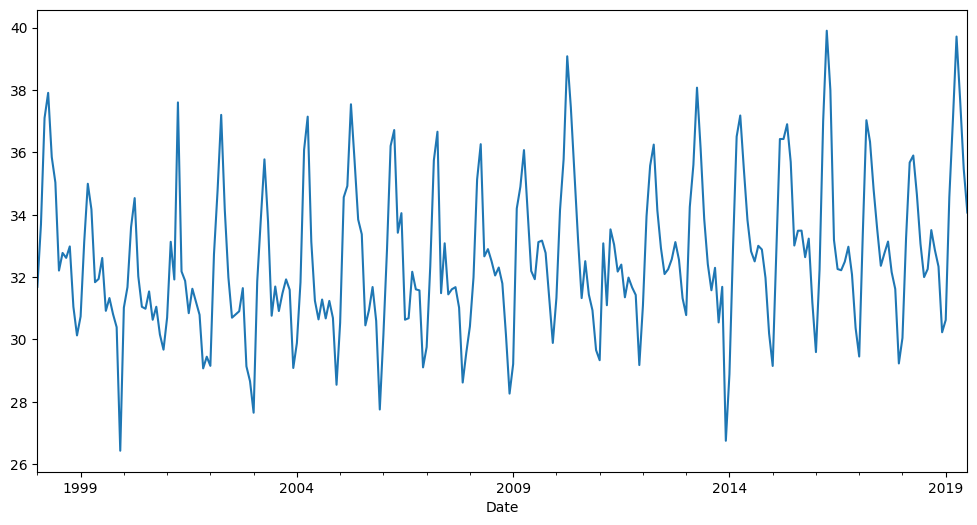

In [79]:
plt.figure(figsize=(12,6))
data_monthly.plot();

In [80]:
train = data_monthly[:-24]
test = data_monthly[-24:]
print(train.info(),end='\n********************\n')
print(test.info())

<class 'pandas.core.series.Series'>
DatetimeIndex: 235 entries, 1998-01-31 to 2017-07-31
Freq: ME
Series name: MaxTemp
Non-Null Count  Dtype  
--------------  -----  
235 non-null    float64
dtypes: float64(1)
memory usage: 3.7 KB
None
********************
<class 'pandas.core.series.Series'>
DatetimeIndex: 24 entries, 2017-08-31 to 2019-07-31
Freq: ME
Series name: MaxTemp
Non-Null Count  Dtype  
--------------  -----  
24 non-null     float64
dtypes: float64(1)
memory usage: 384.0 bytes
None


In [81]:
test.index[0]

Timestamp('2017-08-31 00:00:00')

#1 trend = 'add' , damped = False , seasonal = 'add' , seasonal_periods = 12

In [82]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

es = ExponentialSmoothing(train, trend = 'add', damped=False, seasonal='add', seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict(test.index[0], test.index[-1])
print('RMSE:',rmse(test,yhat))

RMSE: 1.1669523392712184


/tmp/ipython-input-3532330361.py:3: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  es = ExponentialSmoothing(train, trend = 'add', damped=False, seasonal='add', seasonal_periods=12)


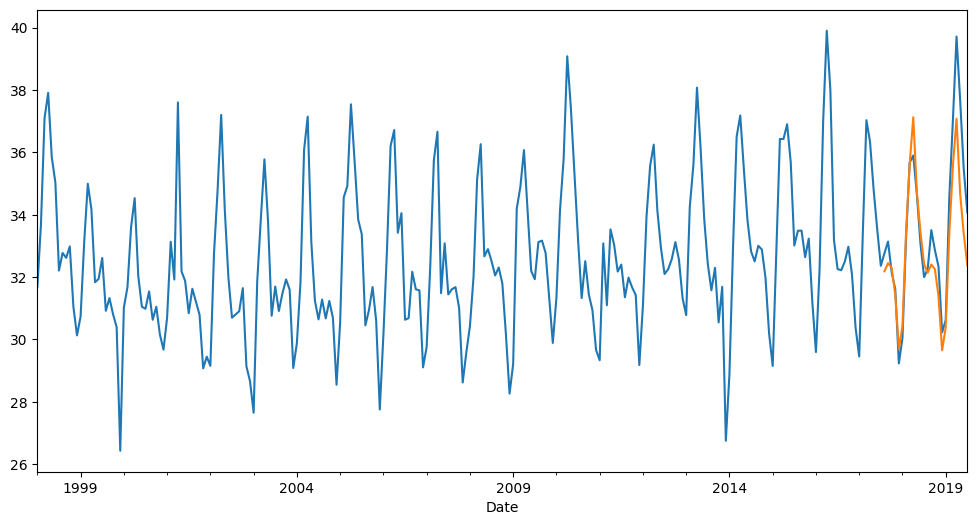

In [83]:
plt.figure(figsize=(12,6))
data_monthly.plot()
yhat.plot();

#2 trend = 'add' , damped = True , seasonal = 'add' , seasonal_periods = 12

In [84]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

es = ExponentialSmoothing(train, trend = 'add', damped=True, seasonal='add', seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict(test.index[0], test.index[-1])
print('RMSE:',rmse(test,yhat))

RMSE: 1.1134955121933203


/tmp/ipython-input-3143546600.py:3: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  es = ExponentialSmoothing(train, trend = 'add', damped=True, seasonal='add', seasonal_periods=12)


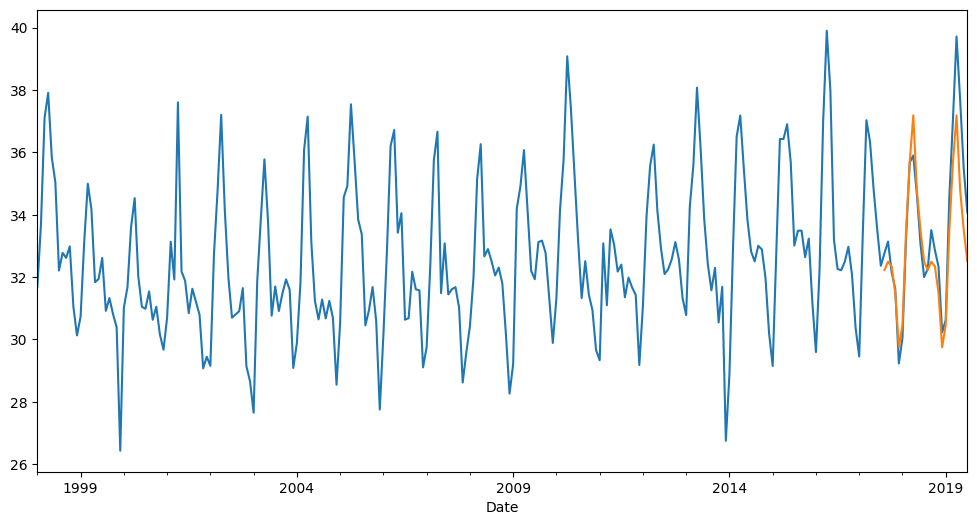

In [85]:
plt.figure(figsize=(12,6))
data_monthly.plot()
yhat.plot();

#3 trend = 'mul' , damped = True , seasonal = 'add' , seasonal_periods = 12

In [86]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

es = ExponentialSmoothing(train, trend = 'mul', damped=True, seasonal='add', seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict(test.index[0], test.index[-1])
print('RMSE:',rmse(test,yhat))

/tmp/ipython-input-3499948584.py:3: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  es = ExponentialSmoothing(train, trend = 'mul', damped=True, seasonal='add', seasonal_periods=12)


RMSE: 0.8958522762071295


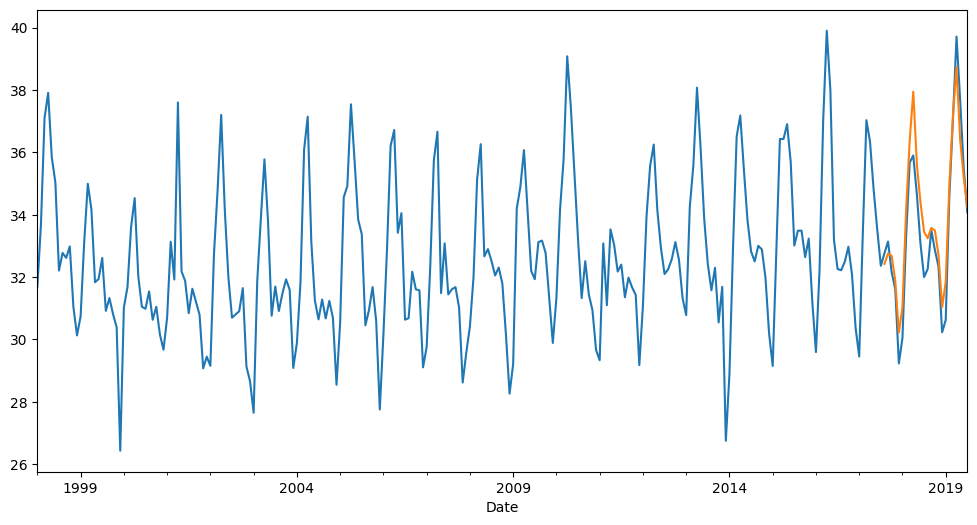

In [87]:
plt.figure(figsize=(12,6))
data_monthly.plot()
yhat.plot();

#4 trend = 'mul' , damped = True , seasonal = 'mul' , seasonal_periods = 12

In [88]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

es = ExponentialSmoothing(train, trend = 'mul', damped=True, seasonal='mul', seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict(test.index[0], test.index[-1])
print('RMSE:',rmse(test,yhat))

/tmp/ipython-input-1281141288.py:3: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  es = ExponentialSmoothing(train, trend = 'mul', damped=True, seasonal='mul', seasonal_periods=12)


RMSE: 1.10643357265325


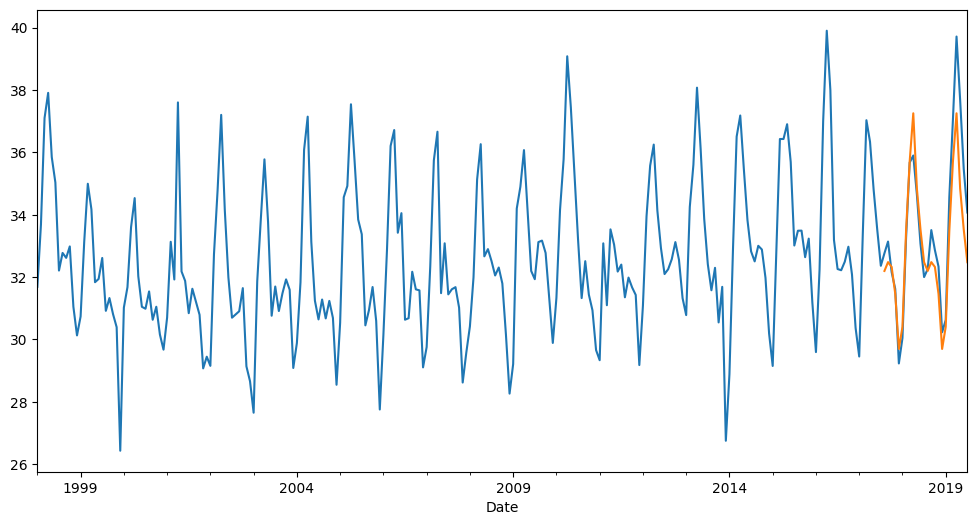

In [89]:
plt.figure(figsize=(12,6))
data_monthly.plot()
yhat.plot();

#5 trend = 'add' , damped = True , seasonal = 'mul' , seasonal_periods = 12

In [90]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

es = ExponentialSmoothing(train, trend = 'add', damped=True, seasonal='mul', seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict(test.index[0], test.index[-1])
print('RMSE:',rmse(test,yhat))

RMSE: 1.1062443526370112


/tmp/ipython-input-2415259326.py:3: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  es = ExponentialSmoothing(train, trend = 'add', damped=True, seasonal='mul', seasonal_periods=12)


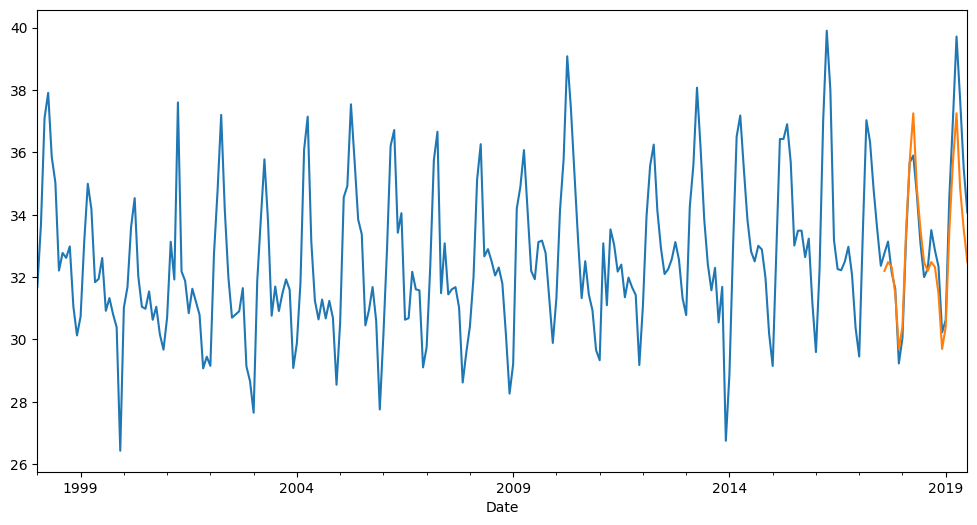

In [91]:
plt.figure(figsize=(12,6))
data_monthly.plot()
yhat.plot();

# การปรับพารามิเตอร์ของ ExponentialSmoothing ที่ได้ค่า RMSE น้อยที่สุดคือ trend = 'mul' , damped = True , seasonal = 'add' , seasonal_periods = 12 มีค่า RMSE เท่ากับ 0.8958522762071295